# Lobbyists4America - (Congressional Tweets Dataset: 2008-2017)

##### Brief:
<br>

Lobbyists4America is a company that seeks to provide insights to their customers (who aim to affect legislation within the US).  They want you to analyze the 2008-2017 congressional tweets in order to understand key topics, members, and relationships within Congress.  These insights will help them focus and strengthen their lobbying efforts.

As lobbyists work for a particular industrial client, they're keen to influence congressman on such issues, this could mean targeting those with high influence, or who are vocal on the subject:
- High influence?
    - How many followers / fans that congressman has
    - Who they interact with most?
        - And about what?
- Vocal on subject?
    - What topics are most discussed in tweets?
        - Of those topics, who discusses them the most?
    - What is the sentiment of each tweet?
    
##### Learning:
<br>

This project will give me an opportunity to look at:
Pyspark, Spark SQL, JSON data files, NLP, Twitter sentiment analysis, Spark ML clustering

In [1]:
import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sparknlp
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from textblob import TextBlob

### Load / Cache Data
- Spark dataframe should split into partitions = 2-3x the no. threads available in your CPU or cluster. I have 2 cores, with 2 threads each = 4, and I chose 3x, ie. 12 partitions, based on experimentation.
- Then cache tables: you can see in Spark GUI that 12 partitions are cached for each file.
- The Shuffle Read is default to 200, we don't want this to be the bottleneck, so we set this equal to partitions in our data, using spark.sql.shuffle.partitions. This is specific to wide shuffle transformations (e.g. GROUP BY or ORDER BY) that may be performed later on, and how many partitions this operation sets up to read the data.

In [2]:
# Tweets
tweets = spark.read.json('../Lobbyists4America1/US_PoliticalTweets/tweets.json').repartition(12).persist()
# Users
users = spark.read.json('../Lobbyists4America1/US_PoliticalTweets/users.json').repartition(12).persist()

spark.sql('SET spark.sql.shuffle.partitions=12')

DataFrame[key: string, value: string]

## EDA

### Users data

In [470]:
users.printSchema()

root
 |-- contributors_enabled: boolean (nullable = true)
 |-- created_at: string (nullable = true)
 |-- default_profile: boolean (nullable = true)
 |-- default_profile_image: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- description: struct (nullable = true)
 |    |    |-- urls: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |-- url: struct (nullable = true)
 |    |    |-- urls: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |-- expanded_url: string (nulla

In [471]:
users.createOrReplaceTempView('users')
spark.sql('SELECT * FROM users LIMIT 2').toPandas()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,has_extended_profile,id,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,False,1302113133,False,False,I am honored to serve the people of Tennessee's 7th District.,"(([],), ([Row(display_url='blackburn.house.gov', expanded_url='http://blackburn.house.gov', indices=[0, 22], url='http://t.co/uIRgQmKWY5')],))",179,False,31906,False,2517,False,False,278145569,278145569,False,False,en,1259,"Brentwood, TN",Marsha Blackburn,False,C0DEED,http://pbs.twimg.com/profile_background_images/378800000010438181/e3f02cef6794fd6777482be977d2850a.png,https://pbs.twimg.com/profile_background_images/378800000010438181/e3f02cef6794fd6777482be977d2850a.png,True,None,http://pbs.twimg.com/profile_images/1302245568/Twitter_profile_normal.JPG,https://pbs.twimg.com/profile_images/1302245568/Twitter_profile_normal.JPG,0084B4,FFFFFF,DDEEF6,333333,True,False,MarshaBlackburn,5338,Atlantic Time (Canada),none,http://t.co/uIRgQmKWY5,-10800,True
1,False,1236024242,False,False,"Member of Congress, Chairman of @transport, and member of @hascrepublicans. Proudly representing the people of PA's 9th district.","(([],), ([Row(display_url='shuster.house.gov', expanded_url='http://shuster.house.gov', indices=[0, 22], url='http://t.co/cXqRPxrbJ1')],))",7,False,17424,False,1047,False,False,22527499,22527499,False,False,en,1149,"Hollidaysburg, PA",Bill Shuster,False,0C0C38,http://pbs.twimg.com/profile_background_images/378800000046588413/29ceb6d23b5bce5e1a561f734b038af6.png,https://pbs.twimg.com/profile_background_images/378800000046588413/29ceb6d23b5bce5e1a561f734b038af6.png,False,https://pbs.twimg.com/profile_banners/22527499/1400702122,http://pbs.twimg.com/profile_images/1181641364/121705WFSPortrait_normal.JPG,https://pbs.twimg.com/profile_images/1181641364/121705WFSPortrait_normal.JPG,2FC2EF,FFFFFF,252429,666666,True,False,RepBillShuster,3142,Eastern Time (US & Canada),none,http://t.co/cXqRPxrbJ1,-14400,True


In [6]:
'''At first look, I will need these columns for my purposes, and need to filter on verified accounts:'''
users_verified = users.select('id','name','location','description','favourites_count',
                              'followers_count','friends_count','verified') \
                        .filter('verified == "True"')

'''Also ranking congress members by followers and friends, to get a relative gauge of popularity'''
users_verified = users_verified.withColumn("followers_rank",
                                           dense_rank().over(Window.orderBy(col("followers_count").desc())))\
                                .withColumn("friends_rank",
                                           dense_rank().over(Window.orderBy(col("friends_count").desc())))\
                                .withColumnRenamed('id','id_user')

In [472]:
# Top followed accounts:
query = '''
SELECT name, followers_count
FROM users
ORDER BY followers_count DESC
'''
spark.sql(query).show()

+------------------+---------------+
|              name|followers_count|
+------------------+---------------+
|   Donald J. Trump|       31712585|
|   President Trump|       18545354|
|    Bernie Sanders|        5072538|
|       Cory Booker|        3094413|
|       Marco Rubio|        2554822|
|  Elizabeth Warren|        2412087|
|       John McCain|        2274034|
|      Nancy Pelosi|        1126205|
|       Jerry Brown|        1119275|
|  Senator Ted Cruz|         960413|
| Governor Christie|         869256|
|       John Kasich|         755475|
|     Chuck Schumer|         591618|
| Senator Tim Kaine|         553125|
|        Trey Gowdy|         552930|
|        John Lewis|         512433|
|Kirsten Gillibrand|         396587|
|     Maxine Waters|         379015|
|          Mike Lee|         314821|
|Rep. Keith Ellison|         313271|
+------------------+---------------+
only showing top 20 rows



In [473]:
# Accounts with most friends
query = '''
SELECT name, friends_count
FROM users
ORDER BY friends_count DESC
'''
spark.sql(query).show()

+-------------------+-------------+
|               name|friends_count|
+-------------------+-------------+
|        Cory Booker|        92934|
|      Amy Klobuchar|        91751|
|       Darrell Issa|        34599|
|      Chuck Schumer|        26536|
|      Jackie Speier|        22246|
|   Rep. Barbara Lee|        16415|
|        Thom Tillis|        15467|
|Congressmember Bass|        14576|
|      ChuckGrassley|        14189|
|        Sandy Levin|        14101|
|   Rep. Jeff Duncan|        13830|
|        Dean Heller|        12022|
|        Mark Warner|        11655|
| Rep. Diana DeGette|        11414|
|      Charlie Baker|        11114|
|         JohnCornyn|        11051|
| Rep. Vern Buchanan|        10929|
|    Pramila Jayapal|        10750|
|        John Kasich|        10072|
|           Judy Chu|         9756|
+-------------------+-------------+
only showing top 20 rows



In [474]:
# Accounts with most favourites
query = '''
SELECT name, favourites_count
FROM users
ORDER BY favourites_count DESC
'''
spark.sql(query).show()

+--------------------+----------------+
|                name|favourites_count|
+--------------------+----------------+
|      Rep. Don Beyer|           12507|
|  Rep. Eric Swalwell|            8034|
|         James Comer|            6764|
|         Jared Polis|            5837|
|          Dina Titus|            5078|
|     Pramila Jayapal|            4457|
|         Larry Hogan|            4456|
|      Rep. Will Hurd|            4419|
|          Doug Ducey|            3860|
|Gov John Bel Edwards|            3848|
|      Richard Hudson|            3554|
|         TeamMoulton|            3525|
|         Steve Cohen|            3231|
|   Rep. Jamie Raskin|            2816|
|    Rep. Barbara Lee|            2778|
|        Andrew Cuomo|            2416|
| Rep. Carlos Curbelo|            2382|
|        Jim Langevin|            2378|
|         David Scott|            2202|
|     Donald Norcross|            2179|
+--------------------+----------------+
only showing top 20 rows



Total no. verified congressmembers on twitter: 530

 Below we see there are a few members with a large following, and many friends. These could be influential in pushing a lobbyist's cause 



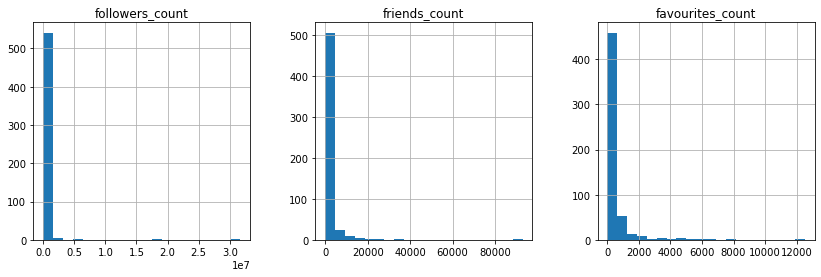

In [475]:
print('Total no. verified congressmembers on twitter:', users.filter('verified == "True"').count())
print("\n Below we see there are a few members with a large following, and many friends. These could be influential in pushing a lobbyist's cause \n")

fig, ax = plt.subplots(ncols=3, figsize=(14,4))
users.select('followers_count').toPandas().hist(bins=20, ax=ax[0])
users.select('friends_count').toPandas().hist(bins=20, ax=ax[1])
users.select('favourites_count').toPandas().hist(bins=20, ax=ax[2]);

### Tweets data

In [476]:
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |--

In [477]:
tweets.createOrReplaceTempView('tweets')
spark.sql('SELECT * FROM tweets LIMIT 2').toPandas()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,screen_name,source,text,truncated,user_id,withheld_copyright,withheld_in_countries,withheld_scope,sentiment,text_nosw
0,None,None,1422545388,"[0, 36]","([], None, [], [], [])",None,5,False,None,560822122088792064,560822122088792064,None,None,None,None,None,False,en,None,None,nan,None,11,False,repsandylevin,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Happy Birthday Chairman @RepPaulRyan,False,25781141,None,None,None,0.80,Happy Birthday Chairman @RepPaulRyan
1,None,None,1492032319,"[0, 136]","([], None, [], [(twitter.com/business/statu…, https://twitter.com/business/status/852270651016720387, [137, 160], https://t.co/LppN1Gv19d)], [])",None,15,False,None,852271434609172482,852271434609172482,None,None,None,None,None,True,en,None,False,852270651016720384.00,852270651016720387,12,False,RepDonaldPayne,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",It's becoming increasingly clear that the Trump administration cares more about protecting loan contractors than student loan borrowers. https://t.co/LppN1Gv19d,False,1155335864,None,None,None,0.35,becoming increasingly clear Trump administration cares protecting loan contractors student loan borrowers. https://t.co/LppN1Gv19d


In [478]:
# At first look, I will need these columns for my purposes, also converted created_at from Unixtime to Datetime
query = '''
SELECT id, user_id, DATE(FROM_UNIXTIME(created_at)) AS created_at, favorite_count, retweet_count, 
tweets.entities.hashtags.text AS hashtags, tweets.entities.user_mentions.id AS mentioned_user_id, 
text, in_reply_to_user_id
FROM tweets
'''
spark.sql(query).show(5,truncate=10)

+----------+----------+----------+--------------+-------------+----------+-----------------+----------+-------------------+
|        id|   user_id|created_at|favorite_count|retweet_count|  hashtags|mentioned_user_id|      text|in_reply_to_user_id|
+----------+----------+----------+--------------+-------------+----------+-----------------+----------+-------------------+
|5608221...|  25781141|2015-01-29|             5|           11|        []|               []|Happy B...|               null|
|8522714...|1155335864|2017-04-12|            15|           12|        []|               []|It's be...|               null|
|6956308...|2987671552|2016-02-05|             0|            5|[BREAKING]|       [570713...|RT @ABC...|               null|
|2637200...| 267938462|2012-10-31|             0|            3|        []|       [673310...|RT @Mic...|               null|
|6996996...| 172858784|2016-02-16|            74|           48|[Hillar...|       [263879...|.@dolor...|          172858784|
+-------

In [479]:
# Most replied-to member:
query = '''
SELECT tweets.entities.user_mentions.name AS mentioned, COUNT(*) as cnt
FROM tweets
GROUP BY tweets.entities.user_mentions.name
ORDER BY cnt DESC
'''
spark.sql(query).show(truncate=50)

+---------------------+------+
|            mentioned|   cnt|
+---------------------+------+
|                   []|616855|
|    [President Trump]|  8242|
|  [House Republicans]|  4706|
|    [Donald J. Trump]|  3454|
|          [Paul Ryan]|  2953|
|       [John Boehner]|  2398|
|    [The White House]|  2213|
|[Energy and Commerce]|  1925|
|     [Ways and Means]|  1866|
|[Oversight Committee]|  1709|
|[Wall Street Journal]|  1589|
|           [The Hill]|  1540|
|    [House Democrats]|  1428|
|       [Barack Obama]|  1316|
|    [Washington Post]|  1301|
|           [U.S. EPA]|  1245|
|     [Kevin McCarthy]|  1212|
|  [House Judiciary ⚖]|  1197|
|       [Nancy Pelosi]|  1131|
|           [Fox News]|  1105|
+---------------------+------+
only showing top 20 rows




Twitter was more popular with congress members in the latter part of the date-range, this may mean that issues
that were more topical around this time will feature more heavily in our dataset
      


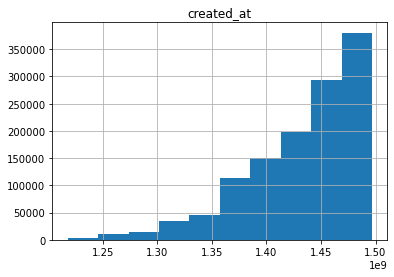

In [480]:
print('''
Twitter was more popular with congress members in the latter part of the date-range, this may mean that issues
that were more topical around this time will feature more heavily in our dataset
      ''')
spark.sql('SELECT created_at FROM tweets').toPandas().hist();

In [481]:
# Which are the most mentioned users
print('Top 20 @mentions by count')

query = '''
SELECT tweets.entities.user_mentions.name AS mentions, COUNT(*) as cnt
FROM tweets
GROUP BY mentions
ORDER BY cnt DESC
'''

spark.sql(query).show()

Top 20 @mentions by count
+--------------------+------+
|            mentions|   cnt|
+--------------------+------+
|                  []|616855|
|   [President Trump]|  8242|
| [House Republicans]|  4706|
|   [Donald J. Trump]|  3454|
|         [Paul Ryan]|  2953|
|      [John Boehner]|  2398|
|   [The White House]|  2213|
|[Energy and Comme...|  1925|
|    [Ways and Means]|  1866|
|[Oversight Commit...|  1709|
|[Wall Street Jour...|  1589|
|          [The Hill]|  1540|
|   [House Democrats]|  1428|
|      [Barack Obama]|  1316|
|   [Washington Post]|  1301|
|          [U.S. EPA]|  1245|
|    [Kevin McCarthy]|  1212|
| [House Judiciary ⚖]|  1197|
|      [Nancy Pelosi]|  1131|
|          [Fox News]|  1105|
+--------------------+------+
only showing top 20 rows



In [482]:
# Which are the most popular hashtags
query = '''
SELECT tweets.entities.hashtags.text AS hashtags, COUNT(*) as cnt
FROM tweets
GROUP BY hashtags
ORDER BY cnt DESC
'''
spark.sql(query).show()

+------------+------+
|    hashtags|   cnt|
+------------+------+
|          []|631433|
| [Obamacare]|  6135|
|      [SOTU]|  3643|
|[mepolitics]|  3291|
|       [ACA]|  2613|
|     [utpol]|  2396|
|    [SCOTUS]|  1780|
|       [IRS]|  1774|
| [Trumpcare]|  1722|
|  [IranDeal]|  1666|
|      [tcot]|  1602|
|  [veterans]|  1509|
| [BetterWay]|  1432|
|      [Iran]|  1393|
|  [Benghazi]|  1373|
|        [FF]|  1345|
|      [VA10]|  1327|
| [ObamaCare]|  1315|
| [TrumpCare]|  1283|
|      [Zika]|  1245|
+------------+------+
only showing top 20 rows



In [483]:
# Which are the most popular hashtags - eg for 2017:
query = '''
SELECT tweets.entities.hashtags.text AS hashtags, COUNT(*) AS cnt_2017
FROM tweets
WHERE YEAR(FROM_UNIXTIME(created_at)) == 2017
GROUP BY hashtags
ORDER BY cnt_2017 DESC
'''
spark.sql(query).show()

+----------------+--------+
|        hashtags|cnt_2017|
+----------------+--------+
|              []|  125993|
|     [Trumpcare]|    1722|
|           [ACA]|    1580|
|     [TrumpCare]|    1283|
|     [Obamacare]|     897|
|          [AHCA]|     867|
|     [MuslimBan]|     676|
|  [JointAddress]|     629|
|        [SCOTUS]|     566|
|     [TrumpCuts]|     537|
|[ProtectOurCare]|     501|
|   [TrumpRussia]|     476|
|[ParisAgreement]|     453|
|[PayMoreForLess]|     446|
|   [MemorialDay]|     415|
|    [mepolitics]|     399|
|         [utpol]|     396|
|[FollowTheFacts]|     340|
|   [NoBanNoWall]|     321|
|   [TrumpBudget]|     314|
+----------------+--------+
only showing top 20 rows



In [484]:
# The most popular topic was Healthcare: Which members tweeted about Obamacare the most?

user_tags = tweets.select(tweets.entities.hashtags.text.alias('hashtags'),'user_id','created_at')

user_tags \
.withColumn('hashtags', user_tags['hashtags'].getItem(0).cast("string")) \
.withColumn("year", year(from_unixtime(user_tags['created_at']))) \
.filter('hashtags IN ("Obamacare","ObamaCare")') \
.groupby('hashtags','user_id').count().sort('count',ascending=False) \
.join(users.select(users.id.alias('user_id'),'name'), on='user_id') \
.show()

+----------+---------+-----+--------------------+
|   user_id| hashtags|count|                name|
+----------+---------+-----+--------------------+
| 110545675|Obamacare|  382|         Diane Black|
| 202206694|Obamacare|  369|  Sen. John Barrasso|
|1249982359|Obamacare|  186|    Leader McConnell|
|  76649729|Obamacare|  181|Sen. Lamar Alexander|
|1058256326|Obamacare|  178|  Rep. Chris Collins|
| 190328374|Obamacare|  164|          Tom Graves|
| 963480595|Obamacare|  163|        Mark Meadows|
| 296361085|ObamaCare|  158|  Senator John Thune|
| 296245061|Obamacare|  156|   Rep. Adrian Smith|
|  18030431|Obamacare|  140|        Judge Carter|
|  24735461|ObamaCare|  137|       Pete Sessions|
|  19926675|Obamacare|  131|       RepKevinBrady|
|1058807868|ObamaCare|  131|        Ron DeSantis|
| 235312723|Obamacare|  130|    Scott DesJarlais|
| 233949261|ObamaCare|  128|  Rep. Bill Huizenga|
| 235312723|ObamaCare|  127|    Scott DesJarlais|
| 935368364|Obamacare|  121|     Rep. Mike Kelly|


In [485]:
# Which members tweeted about Trumpcare the most?
user_tags \
.withColumn('hashtags', user_tags['hashtags'].getItem(0).cast("string")) \
.withColumn("year", year(from_unixtime(user_tags['created_at']))) \
.filter('hashtags IN ("Trumpcare")') \
.groupby('hashtags','user_id').count().sort('count',ascending=False) \
.join(users.select(users.id.alias('user_id'),'name'), on='user_id') \
.show()

+----------+---------+-----+--------------------+
|   user_id| hashtags|count|                name|
+----------+---------+-----+--------------------+
| 171598736|Trumpcare|  158|   Senator Bob Casey|
| 242426145|Trumpcare|   98|        Jim McGovern|
|  17494010|Trumpcare|   80|       Chuck Schumer|
| 293131808|Trumpcare|   75|Senator Patty Murray|
| 946549322|Trumpcare|   68|  Sen. Maggie Hassan|
|2962868158|Trumpcare|   64|      Rep. Don Beyer|
|1045110018|Trumpcare|   61|     Rep. Dan Kildee|
|1531521632|Trumpcare|   56|        Joyce Beatty|
| 247334603|Trumpcare|   48| Senator Dick Durbin|
|  84119348|Trumpcare|   45|          Paul Tonko|
|  21406834|Trumpcare|   41|           Ed Markey|
|  18695134|Trumpcare|   40|Senator Bob Menendez|
|1140648348|Trumpcare|   38|D. Wasserman Schultz|
|  15764644|Trumpcare|   35|        Nancy Pelosi|
|1060984272|Trumpcare|   32|      Elizabeth Esty|
|  90639372|Trumpcare|   31|        Dwight Evans|
|  14984637|Trumpcare|   30|     Chellie Pingree|


## Bag of Words / WordCloud
- Interesting to see what themes were most discussed in each year, and by whom.
- Most tweets didn't contain hashtags, so in order to widen the field, I will need to use a Word Vectorizer to parse out the key themes across all tweets.
- I will use NLTK's list of stopwords to conduct stopword removal, and visualise results in wordclouds

In [5]:
'''Remove stopwords'''
def remove_stopwords(x):    
    sw = stopwords.words("english")
    custom_list = ["&amp;","i'm","rt",'today','great','thanks','thank','w/','new','house','America','Americans',
               'Congress','Senate','US','must','help','need','discuss','bill','today','here:','...','-']
    sw_adj = sw
    for custom_word in custom_list:
        sw_adj.append(custom_word)
    
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw_adj:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)
tweets = tweets.withColumn('text_nosw',nosw('text'))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


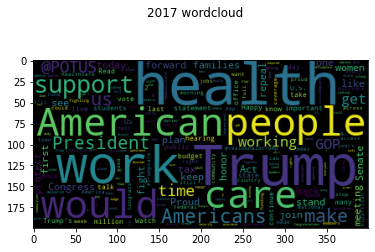

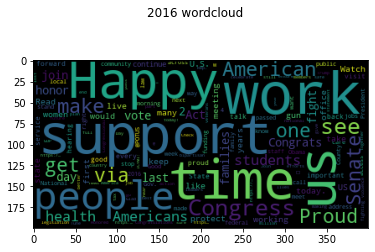

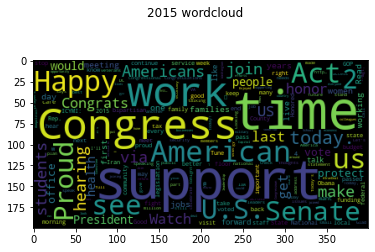

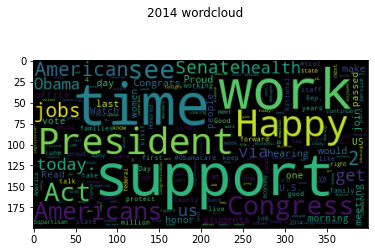

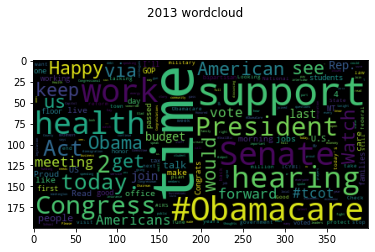

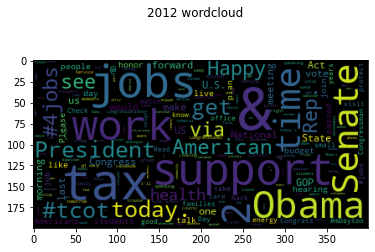

In [17]:
'''Create annual corpora and wordclouds:'''
def flat_list(column):
    corpus = []
    for row in column:
        for w in row.split(' '):
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd \
                    .flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','text') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_tweets(year):
    annual_tweets = tweets.select('text_nosw').filter('YEAR(FROM_UNIXTIME(created_at))=={}'.format(year))
    return annual_tweets

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);


years_list = [2017,2016,2015,2014,2013,2012]

annual_corpora = {}
for year in years_list:
    annual_corpora[str(year)] = corpus_creator(annual_tweets(year))

for key,value in annual_corpora.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))

## Entity Recognition
- The issue with the Bag of Words approach is that non-descriptive words come to the top, which aren't stopwords.
- We turn to Spark NLP's entity recognition now

In [9]:
'''Set up Spark DF inputs for PretrainedPipeline:'''
tweets_2017 = tweets_2017.select('text_nosw').withColumnRenamed('text_nosw','text')
tweets_2016 = tweets_2016.select('text_nosw').withColumnRenamed('text_nosw','text')
tweets_2015 = tweets_2015.select('text_nosw').withColumnRenamed('text_nosw','text')
tweets_2014 = tweets_2014.select('text_nosw').withColumnRenamed('text_nosw','text')
tweets_2013 = tweets_2013.select('text_nosw').withColumnRenamed('text_nosw','text')
tweets_2012 = tweets_2012.select('text_nosw').withColumnRenamed('text_nosw','text')

In [3]:
pipeline = PretrainedPipeline('explain_document_dl', 'en')

explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]


In [ ]:
entities_2017 = pipeline.transform(tweets_2017).select('entities.result')
entities_2016 = pipeline.transform(tweets_2016).select('entities.result')
entities_2015 = pipeline.transform(tweets_2015).select('entities.result')
entities_2014 = pipeline.transform(tweets_2014).select('entities.result')
entities_2013 = pipeline.transform(tweets_2013).select('entities.result')
entities_2012 = pipeline.transform(tweets_2012).select('entities.result')

In [ ]:
def unpack_list(column):
    corpus = []
    for row in column:
        for w in row:
            corpus.append(w)
    return corpus

def corpus_creator_ent(text_col):
    corpus = text_col.rdd \
                    .flatMap(unpack_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF().withColumnRenamed('_1','word') \
                    .withColumnRenamed('_2','count')
    return corpus
#     corpus.write.json("./US_PoliticalTweets/{}.json".format(text_col))

### Potential next steps
- Move the tweets.json file to a cluster or Google Drive in order to use memory and processing capacity of clusters.
- My machine wasn't able to handle Spark NLP's pretrained pipeline to parse out entities, at the same time as flatMapping / reducing by Key to create the corpora.
- For now the code above remains as a placeholder, and also a reminder for future use cases.
- I will use the PretrainedPipeline below to parse out the entities from the corpora that were already created above using a Bag of Words approach, to confirm the themes to focus on.

## Thematic Sentiment Analysis
- Use TextBlob to assign sentiment to each tweet

In [4]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
tweets = tweets.withColumn('sentiment',sentiment('text').cast('double'))

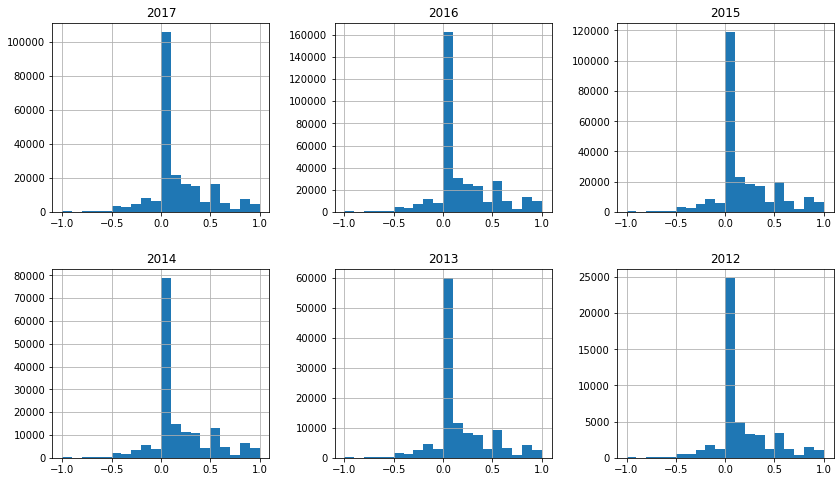

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2017').toPandas().hist(bins=20, ax=ax[0,0])
ax[0,0].set_title('2017')
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2016').toPandas().hist(bins=20, ax=ax[0,1])
ax[0,1].set_title('2016')
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2015').toPandas().hist(bins=20, ax=ax[0,2])
ax[0,2].set_title('2015')
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2014').toPandas().hist(bins=20, ax=ax[1,0])
ax[1,0].set_title('2014')
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2013').toPandas().hist(bins=20, ax=ax[1,1])
ax[1,1].set_title('2013')
tweets.select('sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2012').toPandas().hist(bins=20, ax=ax[1,2])
ax[1,2].set_title('2012');

##### Headline Summary:
- No real difference in overall sentiment distribution by year. At different 'high-level' slices, e.g by year and by overall theme, we find the histogram show the same distribution. So that one could infer that if you zoom out far enough a sample starts to represent the population
- Sentiment is generally very Neutral, however skewed towards the positive. Congress members tend to be advocates for their issues, and want to generate support through positive messaging

### Annual Sentiment Analysis
1. We shall use the annual corpora created above, to guide us on which themes to look into each year
2. We shall look to analyse how sentiment on those themes changed over time.
3. Compare sentiment on Obamacare vs Trumpcare

In [406]:
def conv_string(x):
    string = ''
    for x in x:
        string += x + ' '
    return string

conv_string = udf(conv_string)
spark.udf.register("conv_string", conv_string)

<function __main__.conv_string(x)>

#### 2017 Themes
From the above worclouds we could see the main themes that emerged, we can confirm this below by using Spark-NLP to parse out the entities contained within those wordclouds so we can focus on Nouns and Entities that may correspond the themes / topicss

In [409]:
annotation_2017 = pipeline.transform(corpus_2017)
entities_2017 = annotation_2017.select('text','count',
                                       col('entities.result').alias('entities'),
                                       col('pos.result').alias('pos'))

entstring_2017 = entities_2017.withColumn('entities',conv_string('entities'))\
                                .withColumn('pos',conv_string('pos'))

entstring_2017.filter('entities <> ""').show(50)

+---------------+-----+----------------+-------+
|           text|count|        entities|    pos|
+---------------+-----+----------------+-------+
|          Trump| 7790|          Trump |   NNP |
|       American| 5695|       American |   NNP |
|      Americans| 5010|      Americans |  NNPS |
|            GOP| 4035|            GOP |   NNP |
|       Congress| 3994|       Congress |   NNP |
|          Proud| 3402|          Proud |    JJ |
|         Senate| 2960|         Senate |   NNP |
|        Trump's| 2924|        Trump's |   NNP |
|             US| 2832|             US |   NNP |
|           U.S.| 2691|            U.S | NNP . |
|           #ACA| 2499|           #ACA |   NNP |
|           Read| 2435|           Read |   NNP |
|        America| 2087|        America |   NNP |
|       National| 1953|       National |   NNP |
|     #Trumpcare| 1950|     #Trumpcare |   NNP |
|           I'll| 1853|           I'll |   NNP |
|    Republicans| 1801|    Republicans |  NNPS |
|Congratulations| 16

##### Plots

In [410]:
tweets_sent_2017 = pipeline.transform(tweets.select('id','text','sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2017'))\
                            .select('text',col('entities.result').alias('entities'),col('pos.result').alias('pos'),'sentiment')\
                            .withColumn('entities',conv_string('entities'))\
                            .withColumn('pos',conv_string('pos'))
tweets_sent_2017.show()

+--------------------+--------------------+--------------------+-------------------+
|                text|            entities|                 pos|          sentiment|
+--------------------+--------------------+--------------------+-------------------+
|It's becoming inc...|              Trump |NN VBG RB JJ IN D...|0.35000000000000003|
|We can either be ...|                    |PRP MD CC VB NN I...|                0.0|
|RT @stcharlesgov:...|               NEWS |NNP NN : NNP : NN...|                0.0|
|RT @mtagsummit: P...|&amp Phil DiPofi ...|NNP NN : NNP NN :...|                0.0|
|Last week I intro...|                    |JJ NN PRP VBD JJ ...|0.16666666666666666|
|U.S. added 235,00...|U.S Washington Post |NNP . VBD CD NNS ...|                0.0|
|It was my pleasur...|   @GinaCancelliere |PRP VBD PRP$ NN ,...|                0.0|
|@chrisrouse try b...|                    |NN NN VBG PRP IN ...|                0.0|
|Students from MIQ...|Lemoore Washingto...|NNS IN NNP NN VBD...| 

For 2017 we will take a look at these most prevalent themes:
- Trump / President
- ACA, AHCA, Trumpcare, Protectourcare, obamacare, medicaid

Text(0.5, 1.0, 'Obamacare')

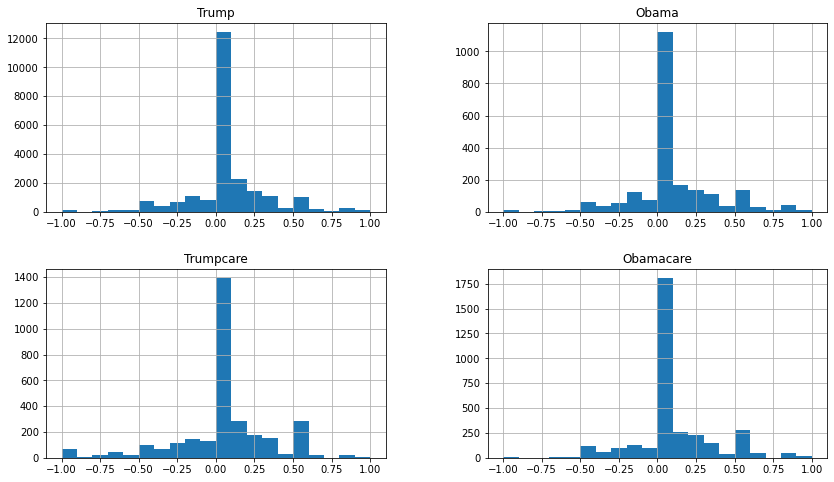

In [413]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
tweets_sent_2017.select('sentiment').filter('text LIKE "%Trump%" AND text NOT LIKE "%Trumpcare%"').toPandas().hist(bins=20, ax=ax[0,0])
ax[0,0].set_title('Trump')
tweets_sent_2017.select('sentiment').filter('text LIKE "%Obama%" AND text NOT LIKE "%Obamacare%"').toPandas().hist(bins=20, ax=ax[0,1])
ax[0,1].set_title('Obama')
tweets_sent_2017.select('sentiment').filter('text LIKE "%Trumpcare%"').toPandas().hist(bins=20, ax=ax[1,0])
ax[1,0].set_title('Trumpcare')
tweets_sent_2017.select('sentiment').filter('text LIKE "%Obamacare%"').toPandas().hist(bins=20, ax=ax[1,1])
ax[1,1].set_title('Obamacare')

#### 2016 Themes
Applying the same analysis as above in 2017, we find these themes surface that we can analyse:
- Trump vs Obama
- Congress / Senate

In [412]:
annotation_2016 = pipeline.transform(corpus_2016)
entities_2016 = annotation_2016.select('text','count',
                                       col('entities.result').alias('entities'),
                                       col('pos.result').alias('pos'))

entstring_2016 = entities_2016.withColumn('entities',conv_string('entities'))\
                                .withColumn('pos',conv_string('pos'))

entstring_2016.filter('entities <> ""').show(50)

+---------------+-----+----------------+-------+
|           text|count|        entities|    pos|
+---------------+-----+----------------+-------+
|       Congress| 6476|       Congress |   NNP |
|       American| 6175|       American |   NNP |
|          Proud| 5566|          Proud |    JJ |
|         Senate| 5265|         Senate |   NNP |
|      Americans| 5057|      Americans |  NNPS |
|             US| 4316|             US |   NNP |
|           U.S.| 4171|            U.S | NNP . |
|           Read| 3712|           Read |   NNP |
|       National| 3021|       National |   NNP |
|          Obama| 2998|          Obama |   NNP |
|         County| 2665|         County |   NNP |
|Congratulations| 2638|Congratulations |   NNP |
|           Join| 2558|           Join |   NNP |
|        America| 2436|        America |   NNP |
|          Trump| 2373|          Trump |   NNP |
|  Congressional| 2330|  Congressional |   NNP |
|            GOP| 2260|            GOP |   NNP |
|           Glad| 21

##### Plots

In [414]:
tweets_sent_2016 = pipeline.transform(tweets.select('id','text','sentiment').filter('YEAR(FROM_UNIXTIME(created_at))==2016'))\
                            .select('text',col('entities.result').alias('entities'),col('pos.result').alias('pos'),'sentiment')\
                            .withColumn('entities',conv_string('entities'))\
                            .withColumn('pos',conv_string('pos'))

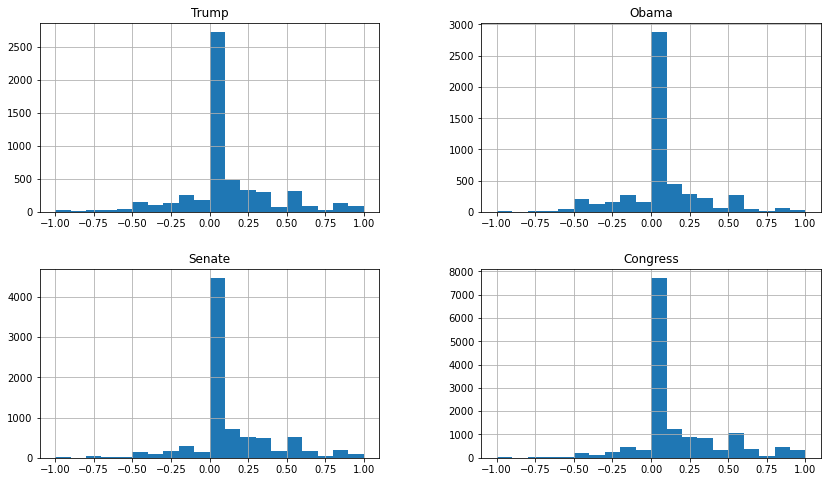

In [415]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
tweets_sent_2016.select('sentiment').filter('text LIKE "%Trump%" AND text NOT LIKE "%Trumpcare%"').toPandas().hist(bins=20, ax=ax[0,0])
ax[0,0].set_title('Trump')
tweets_sent_2016.select('sentiment').filter('text LIKE "%Obama%" AND text NOT LIKE "%Obamacare%"').toPandas().hist(bins=20, ax=ax[0,1])
ax[0,1].set_title('Obama')
tweets_sent_2016.select('sentiment').filter('text LIKE "%Senate%"').toPandas().hist(bins=20, ax=ax[1,0])
ax[1,0].set_title('Senate')
tweets_sent_2016.select('sentiment').filter('text LIKE "%Congress%"').toPandas().hist(bins=20, ax=ax[1,1])
ax[1,1].set_title('Congress');

##### Conclusion:
- No real difference between Trump vs Obama: although you might be able to say Trump was more polarising with slightly higher no. tweets at the extremes.
- Senators and Congressman both naturally congratulatory and positive about themselves and their House
- No. tweets re: Trump increased dramatically this year, during his run to the WH

#### Annual Sentiment Analysis conclusions:
- The distribution is hard to tell apart most topics have similar distributions.
- Trump, Obama, Healthcare are the main themes prevalent across all years: so let's plot sentiment for these over time.
- Look at which members were most positive / negative / active on these main issues. Add followers and friends to see how influential they are

### Sentiment Progression
Below we will chart the progression of sentiment and volume of tweets over time, and repeat this for specific themes

In [3]:
'''Load Spark-NLP's Pretrained Pipeline'''
pipeline = PretrainedPipeline('explain_document_dl', 'en')

explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]


In [4]:
'''Adding sentiment to tweets dataframe'''
def conv_string(x):
    string = ''
    for x in x:
        string += x + ' '
    return string

conv_string = udf(conv_string)
spark.udf.register("conv_string", conv_string)

sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
tweets = tweets.withColumn('sentiment',sentiment('text').cast('double'))

In [7]:
'''Creating the sentiment per tweet view'''
tweets_sent = pipeline.transform(tweets.select('id','text','created_at','sentiment','user_id'))\
                            .select('id','text','created_at',col('entities.result').alias('entities'),col('pos.result').alias('pos'),'sentiment','user_id')\
                            .withColumn('entities',conv_string('entities'))\
                            .withColumn('pos',conv_string('pos'))

'''Adding user information'''
tweets_sent_users = tweets_sent.join(users_verified.select('id_user','name','followers_count','followers_rank','friends_count','friends_rank'),
                                     tweets_sent.user_id==users_verified.id_user, 'left')\
                                .drop('id_user')

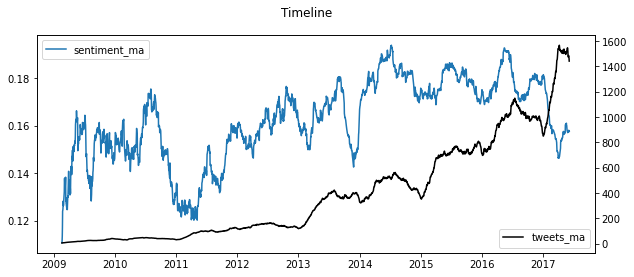

In [9]:
'''Plot 90-day moving averages for sentiment and num_tweets for all tweets'''
overall_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = overall_trend_pdf.sentiment.rolling(window=90).mean()
rolling_tweets = overall_trend_pdf.num_tweets.rolling(window=90).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(overall_trend_pdf.date, rolling_sentiment, label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(overall_trend_pdf.date, rolling_tweets, label='tweets_ma', c='k')
ax1.legend(loc='lower right');

1. The Overall Trend shows sentiment in earlier tweets was more volatile than later, this could simply be due to a higher sample size in the latter period
2. Overall the rolling average sentiment is always in positive territory, not a surprise as members of Congress use Twitter to project a positive image and generate support for their issues.

### Obama trend

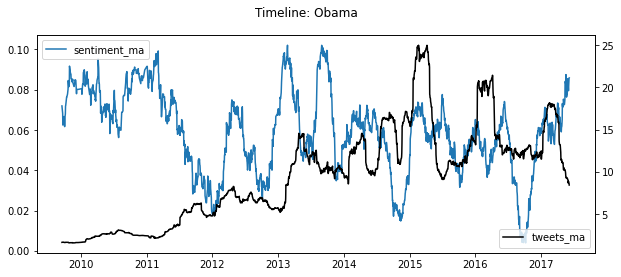

In [416]:
'''Plot 90-day moving averages for sentiment and num_tweets for Obama tweets'''
obama_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .filter('text LIKE "%Obama%" AND text NOT LIKE "%Obamacare%" AND text NOT LIKE "%ObamaCare%"')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = obama_trend_pdf.sentiment.rolling(window=90).mean()
rolling_tweets = obama_trend_pdf.num_tweets.rolling(window=90).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline: Obama')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(obama_trend_pdf.date, rolling_sentiment,label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(obama_trend_pdf.date, rolling_tweets,label='tweets_ma',c='k')
ax1.legend(loc='lower right');

### Trump trend

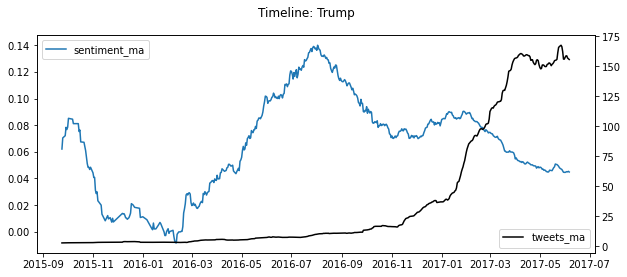

In [417]:
'''Plot 90-day moving averages for sentiment and num_tweets for Trump tweets'''
trump_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .filter('text LIKE "%Trump%" and text NOT LIKE "%Trumpcare%"')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = trump_trend_pdf.sentiment.rolling(window=90).mean()
rolling_tweets = trump_trend_pdf.num_tweets.rolling(window=90).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline: Trump')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(trump_trend_pdf.date, rolling_sentiment,label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(trump_trend_pdf.date, rolling_tweets,label='tweets_ma',c='k')
ax1.legend(loc='lower right');

### ACA vs Obamacare trend

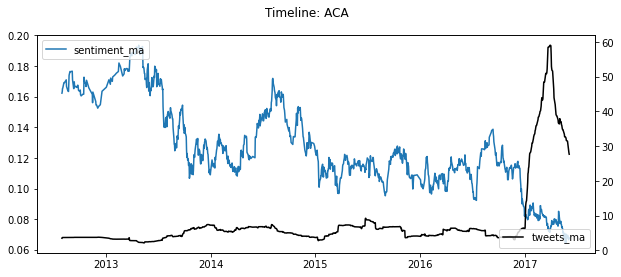

In [418]:
'''Plot 90-day moving averages for sentiment and num_tweets for ACA tweets'''
aca_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .filter('text LIKE "%ACA%"')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = aca_trend_pdf.sentiment.rolling(window=90).mean()
rolling_tweets = aca_trend_pdf.num_tweets.rolling(window=90).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline: ACA')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(aca_trend_pdf.date, rolling_sentiment, label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(aca_trend_pdf.date, rolling_tweets, label='tweets_ma',c='k')
ax1.legend(loc='lower right');

### Obamacare trend

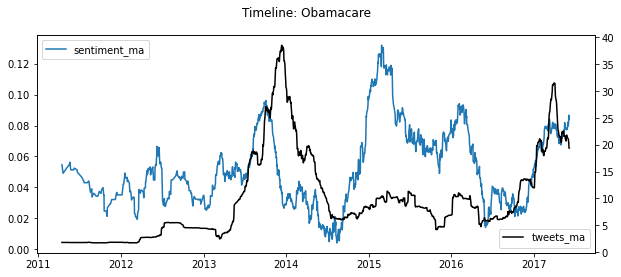

In [419]:
'''Plot 90-day moving averages for sentiment and num_tweets for Obamacare tweets'''
obamacare_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .filter('text LIKE "%Obamacare%"')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = obamacare_trend_pdf.sentiment.rolling(window=90).mean()
rolling_tweets = obamacare_trend_pdf.num_tweets.rolling(window=90).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline: Obamacare')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(obamacare_trend_pdf.date, rolling_sentiment, label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(obamacare_trend_pdf.date, rolling_tweets, label='tweets_ma',c='k')
ax1.legend(loc='lower right');

In [92]:
'''The most negative congressman on Obamacare / ACA'''
tweets_sent_users.select('name','friends_rank','followers_rank','sentiment','text')\
                .filter('text LIKE "%Obamacare%" OR text LIKE "%ACA%"')\
                .groupby('name','friends_rank','followers_rank').agg({'sentiment':'avg','text':'count'})\
                .where('count(text)>50')\
                .orderBy('avg(sentiment)')\
                .show()

+--------------------+------------+--------------+--------------------+-----------+
|                name|friends_rank|followers_rank|      avg(sentiment)|count(text)|
+--------------------+------------+--------------+--------------------+-----------+
|          Joni Ernst|         462|           157|-0.13792393717393714|         65|
|         John McCain|         374|             7|-0.05614046307228125|         77|
|          Tom Cotton|         375|            72|-0.05344482561463694|        106|
| Rep. Roger Williams|         279|           457|-0.05195022514299...|         83|
|        Steve Pearce|         250|           383| -0.0222182867637413|         55|
|       Virginia Foxx|         166|           250|-0.00458282033970...|        109|
|        Steve Daines|         283|           310|0.005102915951972556|         53|
| U.S. Rep. Bob Latta|          31|           155|0.005412829594647779|        110|
|   Steve Chabot 🇺🇸|          70|           238|0.007572899683289...|       

In [93]:
'''The most positive congressman on Obamacare / ACA'''
tweets_sent_users.select('name','friends_rank','followers_rank','sentiment','text')\
                .filter('text LIKE "%Obamacare%" OR text LIKE "%ACA%"')\
                .groupby('name','friends_rank','followers_rank').agg({'sentiment':'avg','text':'count'}).where('count(text)>50')\
                .orderBy('avg(sentiment)',ascending=False)\
                .show()

+--------------------+------------+--------------+-------------------+-----------+
|                name|friends_rank|followers_rank|     avg(sentiment)|count(text)|
+--------------------+------------+--------------+-------------------+-----------+
|  Rep. Tony Cárdenas|         159|           348|0.15888544171877506|         90|
|    Linda T. Sánchez|         126|           204|0.14840254395809951|         81|
| Rep. Alan Lowenthal|          66|           260| 0.1430543993043993|         78|
|          Gwen Moore|         141|           220|0.14239088088106983|        172|
|      David E. Price|          97|           311|0.13920820274323456|        157|
|    Rep. Kristi Noem|         384|           215|0.13654943783068785|         66|
|            Judy Chu|          20|           132|0.13209506178256178|        148|
|    Raul M. Grijalva|         405|           164|0.13155299386359995|        132|
|   Rep. Hank Johnson|         262|           180|0.12775438846867415|         91|
|   

### Trumpcare trend

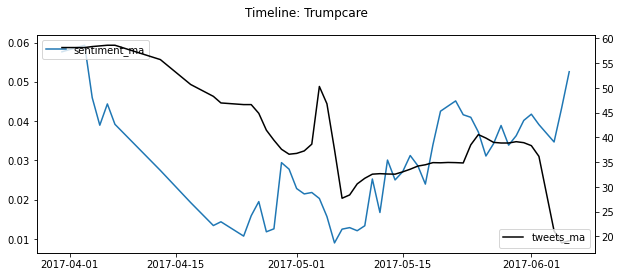

In [138]:
'''Plot 30-day moving averages for sentiment and num_tweets for Trumpcare tweets'''
trumpcare_trend_pdf = tweets_sent.select(to_date(from_unixtime(col('created_at'))).alias('date'),'sentiment','id')\
                            .filter('text LIKE "%Trumpcare%"')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

rolling_sentiment = trumpcare_trend_pdf.sentiment.rolling(window=30).mean()
rolling_tweets = trumpcare_trend_pdf.num_tweets.rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(10,4), sharex=True)
fig.suptitle('Timeline: Trumpcare')

ax0 = plt.subplot(111)
ax1 = ax0.twinx()

ax0.plot(trumpcare_trend_pdf.date, rolling_sentiment, label='sentiment_ma')
ax0.legend(loc='upper left')
ax1.plot(trumpcare_trend_pdf.date, rolling_tweets, label='tweets_ma',c='k')
ax1.legend(loc='lower right');

## Congress members' correlation
Can we discern a correlation between members using sentiment expressed in e.g. healthcare-related tweets? Or even across a wider set of issues and see if we can build up a picture of likeminded individuals?

In [281]:
'''Tweeters' sentiments per theme ranked'''
aca_rank = tweets_sent_users.select('user_id','sentiment','text')\
                                .filter('text LIKE "%ACA%"')\
                                .groupby('user_id').agg({'sentiment':'avg','text':'count'})\
                                .where('count(text)>10')\
                                .orderBy('avg(sentiment)',ascending=False)\
                                .withColumnRenamed('avg(sentiment)','aca_sent')\
                                .withColumnRenamed('count(text)','aca_tweetsnum')\
                                .withColumn('aca_sentrank',
                                           rank().over(Window.orderBy(col('aca_sent').desc())))\
                                .withColumn('aca_tweetsrank',
                                           rank().over(Window.orderBy(col('aca_tweetsnum').desc())))

obamacare_rank = tweets_sent_users.select('user_id','sentiment','text')\
                                .filter('lower(text) LIKE "%obamacare%"')\
                                .groupby('user_id').agg({'sentiment':'avg','text':'count'})\
                                .where('count(text)>10')\
                                .orderBy('avg(sentiment)',ascending=False)\
                                .withColumnRenamed('avg(sentiment)','obamacare_sent')\
                                .withColumnRenamed('count(text)','obamacare_tweetsnum')\
                                .withColumn('obamacare_sentrank',
                                           rank().over(Window.orderBy(col('obamacare_sent').desc())))\
                                .withColumn('obamacare_tweetsrank',
                                           rank().over(Window.orderBy(col('obamacare_tweetsnum').desc())))

In [282]:
'''Appending to user data'''
users_rank = tweets_sent_users.select('user_id','name','followers_rank','friends_rank').distinct()\
                        .join(aca_rank, ['user_id'])\
                        .join(obamacare_rank, ['user_id'])\
                        .na.fill(0)

In [283]:
'''Creating vectors for Spearman Rank correlation'''
correl_data = [(Vectors.dense(users_rank.select('aca_sent').rdd.map(lambda x: x[0]).collect()),),
               (Vectors.dense(users_rank.select('obamacare_sent').rdd.map(lambda x: x[0]).collect()),)]
correl_sdf = spark.createDataFrame(correl_data, ['features']).persist()

In [284]:
'''Spearman Rank correlation, and converting to Pandas Dataframe for easy visualisation'''
pd.DataFrame(Correlation.corr(correl_sdf,'features','spearman').head()[0].toArray(),
             index=users_rank.select('name').rdd.map(lambda x: x[0]).collect(),
             columns=users_rank.select('name').rdd.map(lambda x: x[0]).collect())

,Rep. Keith Ellison,Sen. Lisa Murkowski,Sandy Levin,Mike Lee,Dwight Evans,Rep. Mark Pocan,Rep. Don Beyer,John Shimkus,Raul M. Grijalva,Bernie Sanders,Adam Schiff,Brian Schatz,Matt Cartwright,"Rep. Andy Harris, MD",Mark Takano,Cory Booker,Glenn 'GT' Thompson,Rep. Mike Coffman,Rep. Sam Graves,Rep. Frank Pallone,Louise Slaughter,Rep. Norma Torres,Linda T. Sánchez,Rep. Ted Lieu,Rep. Ed Perlmutter,Jackie Speier,Judy Chu,Rep David Schweikert,Joaquin Castro,Jan Schakowsky,Rep. Lou Barletta,Marsha Blackburn,Rep. Luke Messer,Ted Yoho,U.S. Rep. Bob Latta,Gwen Moore,Rep. Tim Murphy,Jose E. Serrano,G. K. Butterfield,David Cicilline,Rep. Dan Kildee,Rep. Diana DeGette,Jim McGovern,Rep. Kevin Yoder,Dave Joyce,Rep. Tony Cárdenas,Senator Ben Sasse,"Larry Bucshon, MD",Congressmember Bass,Rep. Alan Lowenthal,Alma S. Adams,Congressman Tim Ryan,Lloyd Doggett,Senator Todd Young,Trey Gowdy,Chris Van Hollen,RepKevinBrady,Jim Cooper,Gregory Meeks,US Rep Brendan Boyle,Rep. Randy Hultgren,David E. Price,Steve Chabot 🇺🇸,Rep. Jared Huffman,D. Wasserman Schultz
Rep. Keith Ellison,1.00,-1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00
Sen. Lisa Murkowski,-1.00,1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00
Sandy Levin,1.00,-1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00
Mike Lee,-1.00,1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00
Dwight Evans,1.00,-1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00
Rep. Mark Pocan,-1.00,1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00
Rep. Don Beyer,1.00,-1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00
John Shimkus,1.00,-1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1

#### Conclusions:
- The correlations seem plausible as +1 is largely given for those in the same political party, and -1 with those in different political parties.
- We need to use many more 'themes' than just the 2 we used here to get a more nunanced picture of congressman correlation than just +1, -1.
- This runs into the issue that we quickly reduce the number of members that have tweeted enough times on those themes, this is necessary as we've seen: there is a mean reversion the more a member tweets.

## Clustering
- It's quite obvious to see that R vs D is a strong indicator of stance on certain issues, but I don't get a clear picture of the clusters I was looking for. All I have is either a -1 or +1 rank correlation, but I want to get more than 2 clusters.
- Unsupervised Learning could be a good way to find the optimum number of clusters based on the information, and create those cluster of members, based on sentiment and num_tweets:
    - We start with the restricted theme-set above, then we will add more themes to hopefully improve the model.

In [335]:
'''Preparing input data, which needs to be a feature column of vectors'''
vectorAssembler = VectorAssembler(inputCols=['aca_sent','aca_tweetsnum','obamacare_sent','obamacare_tweetsnum'],
                                  outputCol='features')
cluster_sdf = vectorAssembler.transform(users_rank)

scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures")
scalerModel = scaler.fit(cluster_sdf)
cluster_scaled_sdf = scalerModel.transform(cluster_sdf)

In [323]:
'''Optimise for no. clusters through Silhouette score'''
for i in range(2,10):
    bkm = BisectingKMeans(k=i,featuresCol='scaledfeatures')
    model = bkm.fit(cluster_scaled_sdf)
    cluster_sizes = model.summary.clusterSizes
    silhouette = ClusteringEvaluator(featuresCol='scaledfeatures').evaluate(model.transform(cluster_scaled_sdf).select('scaledfeatures','prediction'))
    print('Clusters: {}, Cluster Size: {}, Silhouette: {}'.format(i, cluster_sizes, np.around(silhouette,4)))

Clusters: 2, Cluster Size: [26, 39], Cost: 197.35163274642474, Silhouette: 0.35700346392252
Clusters: 3, Cluster Size: [26, 26, 13], Cost: 160.26519960886986, Silhouette: 0.31734656528160593
Clusters: 4, Cluster Size: [20, 6, 27, 12], Cost: 118.45243007801592, Silhouette: 0.41307196281664404
Clusters: 5, Cluster Size: [20, 6, 21, 6, 12], Cost: 93.77394870554534, Silhouette: 0.4434712947588493
Clusters: 6, Cluster Size: [8, 12, 6, 21, 6, 12], Cost: 70.39823449923745, Silhouette: 0.5024704854350861
Clusters: 7, Cluster Size: [8, 12, 6, 21, 6, 5, 7], Cost: 67.32362526504917, Silhouette: 0.3630726123044958
Clusters: 8, Cluster Size: [11, 9, 3, 3, 13, 14, 6, 6], Cost: 66.80450804515317, Silhouette: 0.2989543659273738
Clusters: 9, Cluster Size: [11, 9, 3, 3, 13, 11, 3, 6, 6], Cost: 58.39547985431993, Silhouette: 0.32087017657610706


In [361]:
'''Choose 6 clusters as this exhibited the highest silhouette score'''
bkm = BisectingKMeans(k=6,featuresCol='scaledfeatures')
model = bkm.fit(cluster_scaled_sdf)
cluster_scaled_sdf = model.transform(cluster_scaled_sdf)
silhouette = ClusteringEvaluator(featuresCol='scaledfeatures')\
                .evaluate(cluster_scaled_sdf.select('scaledfeatures','prediction'))
print('Silhouette score: ', silhouette)

Silhouette score:  0.5024704854350862


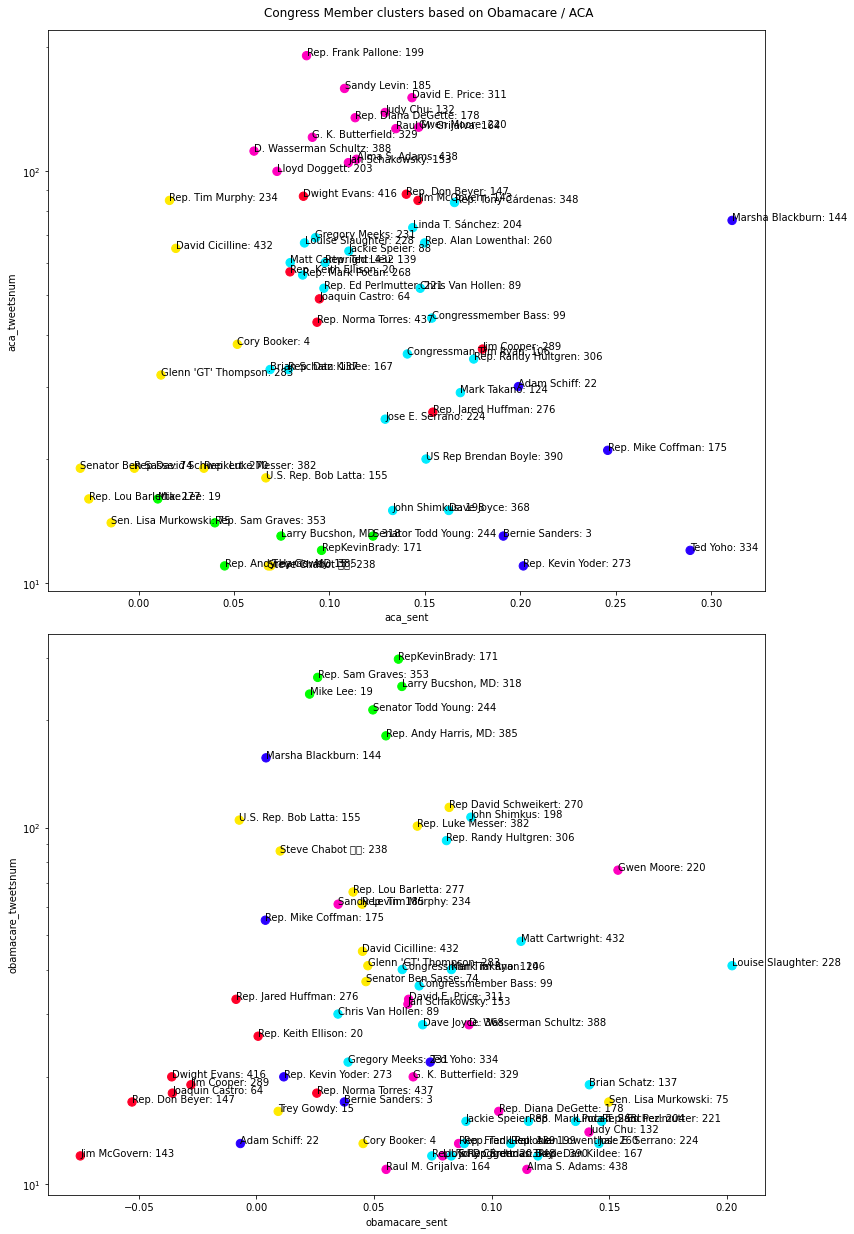

In [469]:
'''Scatter plot of clusters'''
# scatter_pdf = cluster_scaled_sdf.toPandas()
fig, ax = plt.subplots(nrows=2, figsize=(12,18))
plt.suptitle('Congress Member clusters based on Obamacare / ACA')
ax[0].scatter(x=scatter_pdf.aca_sent, y=scatter_pdf.aca_tweetsnum, c=scatter_pdf.prediction, s=70, cmap='gist_rainbow')
for i, xi in enumerate(scatter_pdf.index):
    ax[0].annotate('{}: {}'.format(scatter_pdf.loc[xi,'name'],scatter_pdf.loc[xi,'followers_rank']), (scatter_pdf.loc[xi,'aca_sent'], scatter_pdf.loc[xi,'aca_tweetsnum']))
ax[0].set_xlabel('aca_sent')
ax[0].set_ylabel('aca_tweetsnum')
ax[0].set_yscale('log')
ax[1].scatter(x=scatter_pdf.obamacare_sent, y=scatter_pdf.obamacare_tweetsnum, c=scatter_pdf.prediction, s=70, cmap='gist_rainbow')
for i, xi in enumerate(scatter_pdf.index):
    ax[1].annotate('{}: {}'.format(scatter_pdf.loc[xi,'name'],scatter_pdf.loc[xi,'followers_rank']), (scatter_pdf.loc[xi,'obamacare_sent'], scatter_pdf.loc[xi,'obamacare_tweetsnum']))
ax[1].set_xlabel('obamacare_sent')
ax[1].set_ylabel('obamacare_tweetsnum')
ax[1].set_yscale('log')
plt.tight_layout(rect=[0, 0.03, 1, 0.97]);

## Conclusions
1. Very interesting way to cluster members based on the views / strength of opinion expressed on ACA. The clusters appear to make sense and give us a more nuanced view than just Rep vs Dem.
2. Here we now have 6 clusters of likeminded (sentiment) members who are also similarly motivated (num_tweets) by the issue at hand. I have annotated each point with the member's name, and also where they ranked in no.followers among congressman, e.g Cory Booker, in his cluster, is the one with the most influence if you judge this by no. followers.

## Next Steps
1. This approach can be easily replicated to find clusters for different themes, e.g. foreign policy, energy, tax reforms, etc.